In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.stats import anova as sms_anova

#Changes
alpha = 0.05
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [2]:
#Importing the data from GitHub
churn_raw  = pd.read_csv("https://raw.githubusercontent.com/johnson80245/python/refs/heads/main/csvs/churn_raw_data.csv")
churn = churn_raw.copy()

In [3]:
#Renaming the columns to correct survey response
churn = churn.rename( columns = {
    "CaseOrder" : "case_order",
    "TimeZone" : "time_zone",
    "InternetService" : "internet_service",
    "OnlineSecurity" : "online_security",
    "OnlineBackup" : "online_backup",
    "DeviceProtection" : "device_protections",
    "TechSupport" : "tech_support", 
    "StreamingTV" : "streaming_tv", 
    "StreamingMovies" : "streaming_movies",
    "PaperlessBilling" : "paperless_billing",
    "PaymentMethod" : "payment_method",
    "MonthlyCharge" : "monthly_charge",
    "item1" : "timely_response",
    "item2" : "timely_fixes",
    'item3' : "timely_replacements",
    'item4' : "reliability",
    "item5" : "options",
    "item6" : "respectful_responses",
    "item7" : "courteous_exchange",
    "item8" : "evidence_of_active_listening"
})

In [4]:
#Cleaning column names:
def to_clean(val):
    return val.strip().lower().replace(" ","_")

churn = churn.rename(columns = to_clean)

In [5]:
#Changing mapping of true/false  & yes/no

bool_map = {'False': 0, 'True': 1, 'Yes':1,'No':0}
churn_map = {'Yes':1,'No':0}
bool_cols = ['techie', 'port_modem', 'tablet', 'phone', 'multiple',
           'online_security', 'online_backup', 'device_protections',
           'tech_support', 'streaming_tv', 'streaming_movies', 'paperless_billing']

for column in bool_cols:
    churn[bool_cols] = churn[bool_cols].replace(bool_map)

churn[bool_cols] = churn[bool_cols].replace(bool_map)
churn['churn'] = churn['churn'].replace(bool_map)



C:\Users\Kyle\AppData\Local\Temp\ipykernel_19152\2120568355.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  churn[bool_cols] = churn[bool_cols].replace(bool_map)
C:\Users\Kyle\AppData\Local\Temp\ipykernel_19152\2120568355.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  churn['churn'] = churn['churn'].replace(bool_map)


In [6]:
churn.churn.sample(5)

6552    0
5719    0
6291    0
1164    0
5798    0
Name: churn, dtype: int64

In [7]:
# How to handle outliers:

def fix_outliers_iqr(df, cols, method='cap'):
    for col in cols:
        #Setting IQR 
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        #Method types and how to handle outliers

        #Remove outliers
        if method == 'remove':
            df = df[(df[col] >= lower) & (df[col] <= upper)]
        #Cap at lower and upper IQE
        elif method == 'cap':
            df[col] = np.where(df[col] < lower, lower,
                        np.where(df[col] > upper, upper, df[col]))
        #Use the median to replace those outside the upper/lower
        elif method == 'median':
            median = df[col].median()
            df[col] = np.where((df[col] < lower) | (df[col] > upper), median, df[col])
        #Flag outliers for look 
        elif method == 'flag':
            df[f'{col}_outlier'] = ((df[col] < lower) | (df[col] > upper)).astype(int)

    return df



outlier_col = ['income','tenure','monthly_charge','bandwidth_gb_year']

churn = fix_outliers_iqr(churn,outlier_col,method = 'cap')


In [8]:
#### State stats



In [9]:
churn.head()

,case_order,customer_id,interaction,city,state,county,zip,lat,lng,population,area,timezone,job,children,age,education,employment,income,marital,gender,churn,outage_sec_perweek,email,contacts,yearly_equip_failure,...,contract,port_modem,tablet,internet_service,phone,multiple,online_security,online_backup,device_protections,tech_support,streaming_tv,streaming_movies,paperless_billing,payment_method,tenure,monthly_charge,bandwidth_gb_year,timely_response,timely_fixes,timely_replacements,reliability,options,respectful_responses,courteous_exchange,evidence_of_active_listening
0,1,K409198,aa90260b-4141-4a24-8e36-b04ce1f4f77b,Point Baker,AK,Prince of Wales-Hyder,99927,56.25100,-133.37571,38,Urban,America/Sitka,Environmental health practitioner,NaN,68.0,Master's Degree,Part Time,28561.99,Widowed,Male,0,6.972566,10,0,1,...,One year,1,1,Fiber Optic,1.0,0,1,1,0,0.0,0,1,1,Credit Card (automatic),6.795513,171.449762,904.536110,5,5,5,3,4,4,3,4
1,2,S120509,fb76459f-c047-4a9d-8af9-e0f7d4ac2524,West Branch,MI,Ogemaw,48661,44.32893,-84.24080,10446,Urban,America/Detroit,"Programmer, multimedia",1.0,27.0,Regular High School Diploma,Retired,21704.77,Married,Female,1,12.014541,12,0,1,...,Month-to-month,0,1,Fiber Optic,1.0,1,1,0,0,0.0,1,1,1,Bank Transfer(automatic),1.156681,242.948015,800.982766,3,4,3,3,4,3,4,4
2,3,K191035,344d114c-3736-4be5-98f7-c72c281e2d35,Yamhill,OR,Yamhill,97148,45.35589,-123.24657,3735,Urban,America/Los_Angeles,Chief Financial Officer,4.0,50.0,Regular High School Diploma,Student,NaN,Widowed,Female,0,10.245616,9,0,1,...,Two Year,1,0,DSL,1.0,1,0,0,0,0.0,0,1,1,Credit Card (automatic),15.754144,159.440398,2054.706961,4,4,2,4,4,3,3,3
3,4,D90850,abfa2b40-2d43-4994-b15a-989b8c79e311,Del Mar,CA,San Diego,92014,32.96687,-117.24798,13863,Suburban,America/Los_Angeles,Solicitor,1.0,48.0,Doctorate Degree,Retired,18925.23,Married,Male,0,15.206193,15,2,0,...,Two Year,0,0,DSL,1.0,0,1,0,0,0.0,1,0,1,Mailed Check,17.087227,120.249493,2164.579412,4,4,4,2,5,4,3,3
4,5,K662701,68a861fd-0d20-4e51-a587-8a90407ee574,Needville,TX,Fort Bend,77461,29.38012,-95.80673,11352,Suburban,America/Chicago,Medical illustrator,0.0,83.0,Master's Degree,Student,40074.19,Separated,Male,1,8.960316,16,2,1,...,Month-to-month,1,0,Fiber Optic,0.0,0,0,0,0,1.0,1,0,0,Mailed Check,1.670972,150.761216,271.493436,4,4,4,3,4,4,4,5


In [10]:

#Age missing values:
# Using the median values by state

state_age_med = churn.groupby('state')['age'].median()
churn['age'] = churn.apply(lambda row: state_age_med[row['state']] if pd.isna(row['age']) and row['state'] in state_age_med else row['age'],axis=1)


#Create age group segments to apply to churn 
def segment_age_group(age):
    if pd.isna(age):
        return 'Unknown'
    if age < 18:
        return 'Under 18'
    if age <= 29:
        return '18-29'
    start = (age // 10) * 10
    end = start + 9
    return f"{int(start)}-{int(end)}"

churn['age_group'] = churn['age'].apply(segment_age_group)


# INCOME
income_medians = churn.groupby(['state', 'age_group'])['income'].median().to_dict()
income_overall_median = churn['income'].median()

churn['income'] = churn.apply(
    lambda row: income_medians.get((row['state'], row['age_group']))
    if pd.isna(row['income']) and not pd.isna(income_medians.get((row['state'], row['age_group'])))
    else income_overall_median if pd.isna(row['income'])
    else row['income'],
    axis=1
)


# CHILDREN
child_medians = churn.groupby(['state', 'age_group'])['children'].median().to_dict()
child_overall_median = churn['children'].median()

churn['children'] = churn.apply(
    lambda row: child_medians.get((row['state'], row['age_group']))
    if pd.isna(row['children']) and not pd.isna(child_medians.get((row['state'], row['age_group'])))
    else child_overall_median if pd.isna(row['children'])
    else row['children'],
    axis=1
)


# TECHIE
techie_medians = churn.groupby(['state', 'age_group'])['techie'].median().to_dict()
techie_overall_median = churn['techie'].median()

churn['techie'] = churn.apply(
    lambda row: techie_medians.get((row['state'], row['age_group']))
    if pd.isna(row['techie']) and not pd.isna(techie_medians.get((row['state'], row['age_group'])))
    else techie_overall_median if pd.isna(row['techie'])
    else row['techie'],
    axis=1
)


# INTERNET SERVICE (Categorical — uses mode by age_group)
internet_mode = churn.groupby('age_group')['internet_service'].agg(lambda x: x.mode().iloc[0]).to_dict()
internet_overall_mode = churn['internet_service'].mode().iloc[0]

churn['internet_service'] = churn.apply(
    lambda row: internet_mode.get(row['age_group'])
    if pd.isna(row['internet_service']) and row['age_group'] in internet_mode
    else internet_overall_mode if pd.isna(row['internet_service'])
    else row['internet_service'],
    axis=1
)


# PHONE
phone_medians = churn.groupby(['state', 'age_group'])['phone'].median().to_dict()
phone_overall_median = churn['phone'].median()

churn['phone'] = churn.apply(
    lambda row: phone_medians.get((row['state'], row['age_group']))
    if pd.isna(row['phone']) and not pd.isna(phone_medians.get((row['state'], row['age_group'])))
    else phone_overall_median if pd.isna(row['phone'])
    else row['phone'],
    axis=1
)


# TECH SUPPORT
tech_medians = churn.groupby(['state', 'age_group'])['tech_support'].median().to_dict()
tech_overall_median = churn['tech_support'].median()

churn['tech_support'] = churn.apply(
    lambda row: tech_medians.get((row['state'], row['age_group']))
    if pd.isna(row['tech_support']) and not pd.isna(tech_medians.get((row['state'], row['age_group'])))
    else tech_overall_median if pd.isna(row['tech_support'])
    else row['tech_support'],
    axis=1
)


# TENURE
tenure_medians = churn.groupby(['state', 'age_group'])['tenure'].median().to_dict()
tenure_overall_median = churn['tenure'].median()

churn['tenure'] = churn.apply(
    lambda row: tenure_medians.get((row['state'], row['age_group']))
    if pd.isna(row['tenure']) and not pd.isna(tenure_medians.get((row['state'], row['age_group'])))
    else tenure_overall_median if pd.isna(row['tenure'])
    else row['tenure'],
    axis=1
)


# BANDWIDTH_GB_YEAR
band_medians = churn.groupby(['state', 'age_group'])['bandwidth_gb_year'].median().to_dict()
band_overall_median = churn['bandwidth_gb_year'].median()

churn['bandwidth_gb_year'] = churn.apply(
    lambda row: band_medians.get((row['state'], row['age_group']))
    if pd.isna(row['bandwidth_gb_year']) and not pd.isna(band_medians.get((row['state'], row['age_group'])))
    else band_overall_median if pd.isna(row['bandwidth_gb_year'])
    else row['bandwidth_gb_year'],
    axis=1
)

In [11]:
churn = fix_outliers_iqr(churn,outlier_col,method = 'cap')

In [12]:
def univar(df,val):
  

    print("The Information Below is For:", val)
    
    plt.hist(df[val])
    plt.show()
    
    red_circle = dict(marker='o', markerfacecolor='red', markersize=6)
    mean_shape = dict(marker='D', markerfacecolor='blue', markersize=6)

    df[val].plot(kind='box',
                vert=False,
                flierprops=red_circle,
                showmeans=True,
                meanprops=mean_shape,
                notch=True)
    plt.show()
    
    print(df[val].describe().round(3))

    print("-------------------------------")
    print("The mode is:",df[val].mode()[0])
    
    print("____________________________________________")

In [13]:
#Cast as categorical data

cat_cols = ['case_order', 'customer_id', 'interaction', 'city', 'state', 'county',
            'area', 'timezone', 'job', 'education', 'employment',
            'marital', 'gender', 'churn', 'techie', 'contract',
            'port_modem', 'tablet', 'internet_service', 'phone', 'multiple',
            'online_security', 'online_backup', 'device_protections', 'tech_support', 'streaming_tv',
            'streaming_movies', 'paperless_billing', 'payment_method']

# 'timely_response', 'timely_fixes',
#             'timely_replacements', 'reliability', 'options', 'respectful_responses',
#             'courteous_exchange', 'evidence_of_active_listening'


for column in cat_cols:
    churn[column] = churn[column].astype('category')

In [14]:
#Describe all transformed
churn.describe().T

,count,mean,std,min,25%,50%,75%,max
zip,10000.0,49153.319600,27532.196108,601.000000,26292.500000,48869.500000,71866.500000,99929.000000
lat,10000.0,38.757567,5.437389,17.966120,35.341828,39.395800,42.106908,70.640660
lng,10000.0,-90.782536,15.156142,-171.688150,-97.082812,-87.918800,-80.088745,-65.667850
population,10000.0,9756.562400,14432.698671,0.000000,738.000000,2910.500000,13168.000000,111850.000000
children,10000.0,1.946650,1.910600,0.000000,1.000000,1.000000,3.000000,10.000000
age,10000.0,53.289900,18.040047,18.000000,41.000000,54.000000,65.000000,89.000000
income,10000.0,36875.336247,20295.736894,740.660000,23163.537500,33304.890000,46638.982500,81852.150000
outage_sec_perweek,10000.0,11.452955,7.025921,-1.348571,8.054362,10.202896,12.487644,47.049280
email,10000.0,12.016000,3.025898,1.000000,10.000000,12.000000,14.000000,23.000000
contacts,10000.0,0.994200,0.988466,0.000000,0.000000,1.000000,2.000000,7.000000


In [15]:
#Fileds going to use:

churn = churn[['customer_id', 'state','area','children','age', 'education',
               'employment', 'income','marital','gender','churn',
               'outage_sec_perweek','yearly_equip_failure','contract','internet_service',
               'tech_support','streaming_tv','streaming_movies','tenure',
               'monthly_charge','bandwidth_gb_year', 'timely_response', 'timely_fixes',
               'timely_replacements','reliability','options','respectful_responses',
               'courteous_exchange','evidence_of_active_listening','age_group']]


The Information Below is For: age


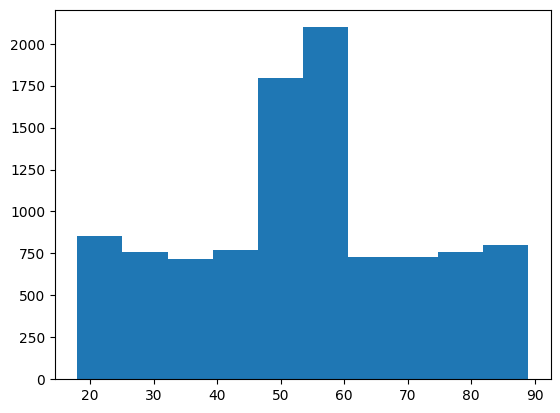

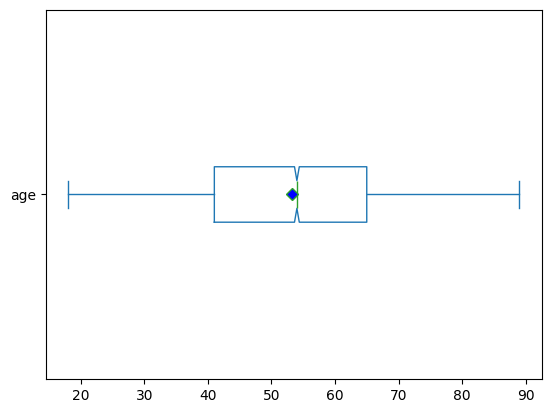

count    10000.00
mean        53.29
std         18.04
min         18.00
25%         41.00
50%         54.00
75%         65.00
max         89.00
Name: age, dtype: float64
-------------------------------
The mode is: 54.0
____________________________________________
The Information Below is For: children


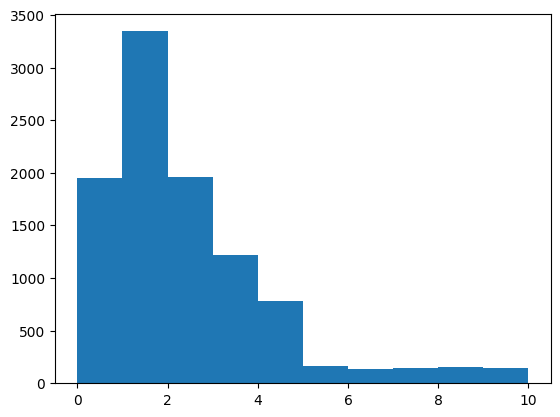

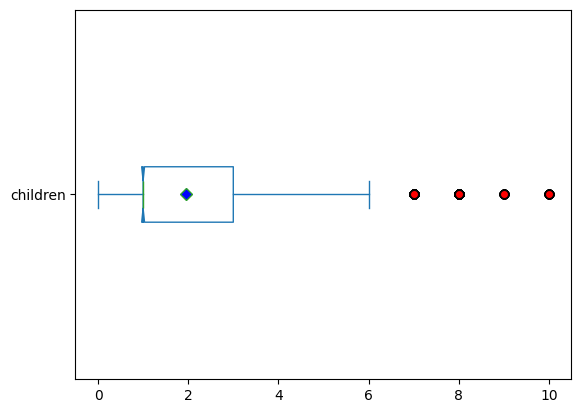

count    10000.000
mean         1.947
std          1.911
min          0.000
25%          1.000
50%          1.000
75%          3.000
max         10.000
Name: children, dtype: float64
-------------------------------
The mode is: 1.0
____________________________________________
The Information Below is For: income


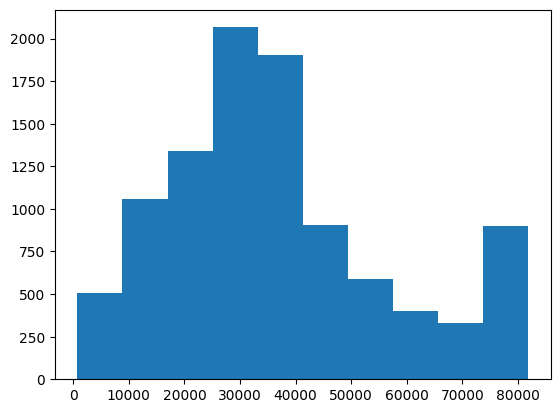

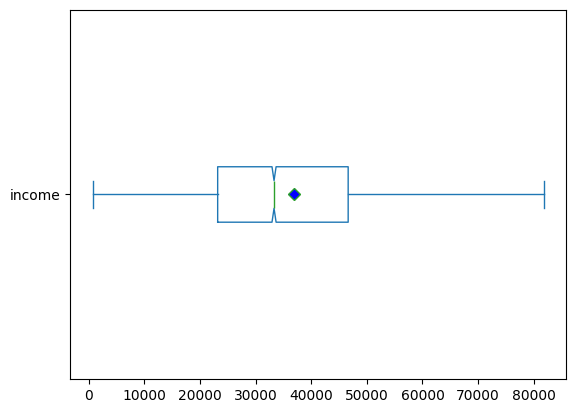

count    10000.000
mean     36875.336
std      20295.737
min        740.660
25%      23163.538
50%      33304.890
75%      46638.982
max      81852.150
Name: income, dtype: float64
-------------------------------
The mode is: 81852.15
____________________________________________
The Information Below is For: monthly_charge


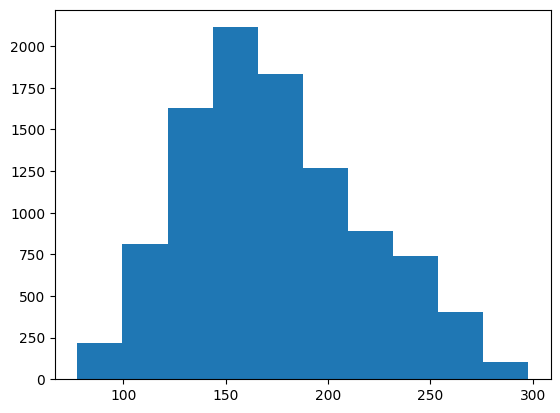

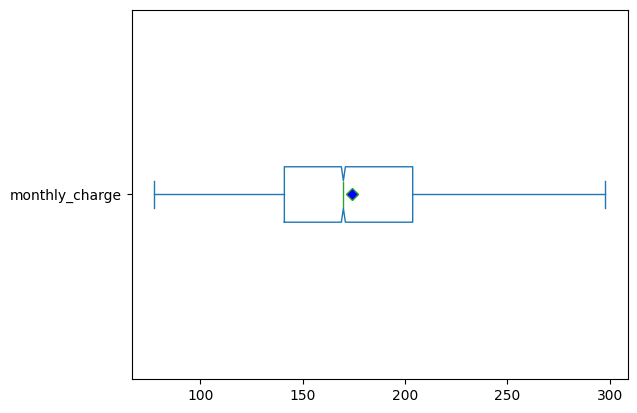

count    10000.000
mean       174.073
std         43.324
min         77.505
25%        141.071
50%        169.915
75%        203.777
max        297.837
Name: monthly_charge, dtype: float64
-------------------------------
The mode is: 297.8369855125
____________________________________________
The Information Below is For: bandwidth_gb_year


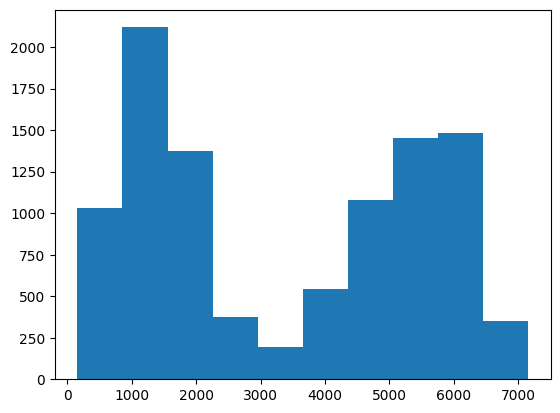

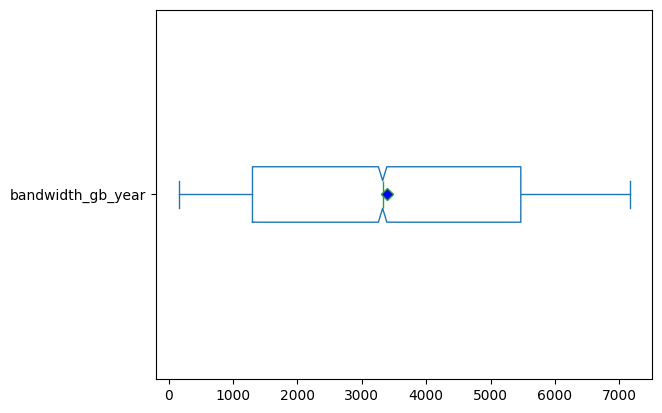

count    10000.000
mean      3387.142
std       2110.914
min        155.507
25%       1302.185
50%       3323.735
75%       5470.032
max       7158.982
Name: bandwidth_gb_year, dtype: float64
-------------------------------
The mode is: 4159.306
____________________________________________


In [16]:

univar(churn,'age')
univar(churn,'children')
univar(churn,'income')
univar(churn,'monthly_charge')
univar(churn,'bandwidth_gb_year')

In [17]:
#Create segments 
#Area
area_segment = churn.groupby(['area','churn'], observed=True)[['tenure','monthly_charge','bandwidth_gb_year','age']].agg('mean').reset_index()

#Age Group
age_segment = churn.groupby(['age_group','churn'], observed=True)[['tenure','monthly_charge','bandwidth_gb_year','age']].agg('mean').reset_index()

#Education
education_segment = churn.groupby(['education','churn'], observed=True)[['tenure','monthly_charge','bandwidth_gb_year','age']].agg('mean').reset_index()

#Churn
churn_segment = churn.groupby(['churn'], observed=True)[['tenure','monthly_charge','bandwidth_gb_year','age']].agg('mean').reset_index()

#Martial
marital_segment = churn.groupby(['marital','churn'], observed=True)[['tenure','monthly_charge','bandwidth_gb_year','age']].agg('mean').reset_index()

#Integers & floats
churn_num = churn.select_dtypes(include = "number")


In [18]:
#Get Dummy Variables
area_dummy = pd.get_dummies(churn.area, prefix = 'area', drop_first = True)
age_group_dummy = pd.get_dummies(churn.age_group, prefix = 'age_group', drop_first = True)
education_dummy = pd.get_dummies(churn.education, prefix= 'education', drop_first = True)
martial_dummy = pd.get_dummies(churn.marital, prefix = 'marital', drop_first = True)

churn = churn.join([area_dummy, age_group_dummy, education_dummy, martial_dummy])



    

churn.sample(5)

,customer_id,state,area,children,age,education,employment,income,marital,gender,churn,outage_sec_perweek,yearly_equip_failure,contract,internet_service,tech_support,streaming_tv,streaming_movies,tenure,monthly_charge,bandwidth_gb_year,timely_response,timely_fixes,timely_replacements,reliability,...,evidence_of_active_listening,age_group,area_Suburban,area_Urban,age_group_30-39,age_group_40-49,age_group_50-59,age_group_60-69,age_group_70-79,age_group_80-89,education_Associate's Degree,education_Bachelor's Degree,education_Doctorate Degree,education_GED or Alternative Credential,education_Master's Degree,education_No Schooling Completed,education_Nursery School to 8th Grade,education_Professional School Degree,education_Regular High School Diploma,"education_Some College, 1 or More Years, No Degree","education_Some College, Less than 1 Year",marital_Married,marital_Never Married,marital_Separated,marital_Widowed
381,L72577,NY,Rural,1.0,46.0,Master's Degree,Part Time,40957.31,Married,Female,1,15.967772,2,One year,DSL,0.0,0,1,11.168474,160.229827,1599.727567,3,3,4,4,...,5,40-49,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False
3297,G250165,NC,Urban,2.0,54.0,Nursery School to 8th Grade,Full Time,23753.54,Widowed,Female,1,8.995083,0,Month-to-month,DSL,0.0,0,0,3.088732,94.385500,785.299400,5,5,4,3,...,4,50-59,False,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True
8004,U549585,NY,Rural,1.0,57.0,Nursery School to 8th Grade,Unemployed,14636.41,Separated,Female,0,5.834109,0,Month-to-month,DSL,1.0,0,0,55.367790,126.376700,5205.865000,5,4,4,4,...,5,50-59,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False
2220,G17131,SC,Suburban,2.0,51.0,Bachelor's Degree,Student,33578.92,Widowed,Male,0,38.700744,0,Two Year,Fiber Optic,1.0,0,0,3.089663,181.129858,634.965917,5,5,4,3,...,3,50-59,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True
5424,S904300,OH,Urban,1.0,51.0,Doctorate Degree,Full Time,32521.54,Separated,Female,0,6.554108,0,One year,Fiber Optic,1.0,0,1,64.617660,225.642100,5693.466000,3,3,3,4,...,4,50-59,False,True,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False


In [19]:
churn.sample(5)

,customer_id,state,area,children,age,education,employment,income,marital,gender,churn,outage_sec_perweek,yearly_equip_failure,contract,internet_service,tech_support,streaming_tv,streaming_movies,tenure,monthly_charge,bandwidth_gb_year,timely_response,timely_fixes,timely_replacements,reliability,...,evidence_of_active_listening,age_group,area_Suburban,area_Urban,age_group_30-39,age_group_40-49,age_group_50-59,age_group_60-69,age_group_70-79,age_group_80-89,education_Associate's Degree,education_Bachelor's Degree,education_Doctorate Degree,education_GED or Alternative Credential,education_Master's Degree,education_No Schooling Completed,education_Nursery School to 8th Grade,education_Professional School Degree,education_Regular High School Diploma,"education_Some College, 1 or More Years, No Degree","education_Some College, Less than 1 Year",marital_Married,marital_Never Married,marital_Separated,marital_Widowed
7048,Y489449,FL,Urban,1.0,55.0,Master's Degree,Student,9448.70,Never Married,Female,0,8.379359,0,Month-to-month,Fiber Optic,0.0,1,0,64.439120,107.432600,5577.386000,4,4,4,4,...,3,50-59,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False
2281,N309726,UT,Suburban,0.0,82.0,Regular High School Diploma,Full Time,29906.71,Divorced,Male,1,7.817787,0,Month-to-month,Fiber Optic,0.0,1,1,7.755991,243.525747,1177.660151,3,2,4,3,...,2,80-89,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
4862,J234094,KY,Rural,2.0,63.0,Bachelor's Degree,Full Time,81852.15,Widowed,Male,0,11.910480,0,Two Year,DSL,0.0,0,0,7.761878,105.381100,1231.447000,2,3,2,3,...,4,60-69,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True
2786,W249508,GA,Urban,1.0,78.0,Regular High School Diploma,Full Time,29765.16,Divorced,Female,0,10.345712,1,Month-to-month,DSL,1.0,1,0,4.761845,133.149633,1290.636519,5,4,3,4,...,5,70-79,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
178,B424659,MN,Urban,1.0,34.0,Bachelor's Degree,Full Time,11856.81,Separated,Female,0,12.968826,0,One year,Fiber Optic,1.0,0,1,2.976034,194.060266,830.119301,3,2,3,3,...,4,30-39,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False


In [20]:
churn1 = churn.map(lambda x: 1 if x is True else 0 if x is False else x)

churn1.sample()


,customer_id,state,area,children,age,education,employment,income,marital,gender,churn,outage_sec_perweek,yearly_equip_failure,contract,internet_service,tech_support,streaming_tv,streaming_movies,tenure,monthly_charge,bandwidth_gb_year,timely_response,timely_fixes,timely_replacements,reliability,...,evidence_of_active_listening,age_group,area_Suburban,area_Urban,age_group_30-39,age_group_40-49,age_group_50-59,age_group_60-69,age_group_70-79,age_group_80-89,education_Associate's Degree,education_Bachelor's Degree,education_Doctorate Degree,education_GED or Alternative Credential,education_Master's Degree,education_No Schooling Completed,education_Nursery School to 8th Grade,education_Professional School Degree,education_Regular High School Diploma,"education_Some College, 1 or More Years, No Degree","education_Some College, Less than 1 Year",marital_Married,marital_Never Married,marital_Separated,marital_Widowed
758,F707493,IL,Urban,4.0,74.0,"Some College, Less than 1 Year",Full Time,17520.23,Separated,Female,1,5.13296,1,Month-to-month,DSL,1.0,1,0,3.24817,163.179445,991.763362,4,4,3,5,...,4,70-79,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0


In [21]:
area_dummy.sample(5)

,area_Suburban,area_Urban
6840,True,False
8873,False,True
69,True,False
2005,False,True
2464,False,True


In [22]:
churn = pd.get_dummies(churn, columns=['area', 'age_group', 'education', 'marital'])


In [23]:
churn['churn'] = churn['churn'].astype(int)

In [29]:
churn.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customer_id,10000,10000,A00088,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
state,10000,52,TX,603,NaN,NaN,NaN,NaN,NaN,NaN,NaN
children,10000.0,NaN,NaN,NaN,1.94665,1.9106,0.0,1.0,1.0,3.0,10.0
age,10000.0,NaN,NaN,NaN,53.2899,18.040047,18.0,41.0,54.0,65.0,89.0
employment,10000,5,Full Time,5992,NaN,NaN,NaN,NaN,NaN,NaN,NaN
income,10000.0,NaN,NaN,NaN,36875.336247,20295.736894,740.66,23163.5375,33304.89,46638.9825,81852.15
gender,10000,3,Female,5025,NaN,NaN,NaN,NaN,NaN,NaN,NaN
churn,10000.0,NaN,NaN,NaN,0.265,0.441355,0.0,0.0,0.0,1.0,1.0
outage_sec_perweek,10000.0,NaN,NaN,NaN,11.452955,7.025921,-1.348571,8.054362,10.202896,12.487644,47.04928
yearly_equip_failure,10000.0,NaN,NaN,NaN,0.398,0.635953,0.0,0.0,0.0,1.0,6.0


In [30]:
m1 = smf.ols('churn ~ tenure + monthly_charge + bandwidth_gb_year + children + income + timely_response + timely_fixes + timely_replacements'
             '+ reliability + options + respectful_responses + courteous_exchange + evidence_of_active_listening'
             , data = churn).fit()
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  churn   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     412.6
Date:                Wed, 03 Sep 2025   Prob (F-statistic):               0.00
Time:                        13:17:51   Log-Likelihood:                -3860.1
No. Observations:               10000   AIC:                             7748.
Df Residuals:                    9986   BIC:                             7849.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -0.0729      0.035     -2.072      0.038      -0.142      -0.004
tenure                          -0.0055      0.000    -20.018      0.000      -0.006      -0.005
monthly_charge                   0.0038   8.29e-05     46.138      0.000       0.004       0.004
bandwidth_gb_year            -3.301e-05   3.34e-06     -9.873      0.000   -3.96e-05   -2.65e-05
children                         0.0003      0.002      0.140      0.889      -0.003       0.004
income                         3.86e-07   1.76e-07      2.198      0.028    4.17e-08     7.3e-07
timely_response                 -0.0069      0.005     -1.360      0.174      -0.017       0.003
timely_fixes                    -0.0010      0.005     -0.207      0.836      -0.010       0.008
timely_replacements              0.0020      0.004      0.457      0.648      -0.007       0.011
reliability                     -0.0044      0.004     -1.111      0.267      -0.012       0.003
options                         -0.0026      0.004     -0.640      0.522      -0.011       0.005
respectful_responses             0.0014      0.004      0.345      0.730      -0.007       0.010
courteous_exchange              -0.0016      0.004     -0.396      0.692      -0.009       0.006
evidence_of_active_listening     0.0012      0.004      0.310      0.756      -0.006       0.009
==============================================================================
Omnibus:                      650.875   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              440.704
Skew:                           0.401   Prob(JB):                     2.01e-96
Kurtosis:                       2.356   Cond. No.                     4.19e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.19e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [31]:
import statsmodels.api as sm 
import statsmodels.formula.api as smf

m2 = smf.glm('churn ~ tenure + monthly_charge + bandwidth_gb_year + income',
             data = churn, family = sm.families.Binomial()).fit()
m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9995
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3627.9
Date:                Wed, 03 Sep 2025   Deviance:                       7255.8
Time:                        13:17:54   Pearson chi2:                 8.29e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3501
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -4.7901      0.153    -31.393      0.000      -5.089      -4.491
tenure               -0.0472      0.002    -19.602      0.000      -0.052      -0.042
monthly_charge        0.0311      0.001     37.059      0.000       0.029       0.033
bandwidth_gb_year    -0.0003   2.77e-05    -10.070      0.000      -0.000      -0.000
income             3.451e-06   1.44e-06      2.398      0.016     6.3e-07    6.27e-06
=====================================================================================
"""

In [27]:
m2.conf_int()

,0,1
Intercept,-5.089121e+00,-4.490998
tenure,-5.187849e-02,-0.042447
monthly_charge,2.941242e-02,0.032697
bandwidth_gb_year,-3.332433e-04,-0.000225
income,6.304291e-07,0.000006


In [35]:
new_cust = pd.DataFrame([{
    'tenure': 10,
    'monthly_charge': 179,
    'bandwidth_gb_year': 3468,
    'income': 56750
}])
prediction = m2.predict(new_cust)
print("Predicted churn (continuous output): {}".format(prediction.iloc[0]))

Predicted churn (continuous output): 0.38357266940095175
